In [2]:
from tqdm import tqdm
import pandas as pd
import folium
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Function to read station inventory
def read_station_inventory(station_file_path):
    colspecs = [
        (0, 11),    # Station ID
        (12, 20),   # Latitude
        (21, 30),   # Longitude
        (31, 37),   # Elevation
        (38, None)  # Station Name
    ]
    columns = ['station_id', 'latitude', 'longitude', 'elevation', 'name']
    stations = pd.read_fwf(station_file_path, colspecs=colspecs, header=None, names=columns)
    stations['station_id'] = stations['station_id'].str.strip()
    stations['name'] = stations['name'].str.strip()
    stations['latitude'] = pd.to_numeric(stations['latitude'], errors='coerce')
    stations['longitude'] = pd.to_numeric(stations['longitude'], errors='coerce')
    stations['elevation'] = pd.to_numeric(stations['elevation'], errors='coerce')
    stations['country_code'] = stations['station_id'].str[:2]
    return stations

# Function to analyze station data with a progress bar
def analyze_station_data(file_path, station_file_path, start_year, end_year):
    stations = read_station_inventory(station_file_path)
    station_ids = stations['station_id'].tolist()

    # Define the fixed-width columns for the data as per GHCN format
    colspecs = [(0, 11), (11, 15), (15, 19)]
    for i in range(12):
        start = 19 + i * 8
        colspecs.extend([
            (start, start + 5),    # Value
            (start + 5, start + 6),  # MFlag
            (start + 6, start + 7),  # QFlag
            (start + 7, start + 8)   # SFlag
        ])

    # Read the GHCN data in chunks
    chunk_size = 100000
    total_lines = sum(1 for line in open(file_path))  # Estimate total lines for progress tracking
    data_chunks = pd.read_fwf(file_path, colspecs=colspecs, chunksize=chunk_size, header=None)

    columns = ['station_id', 'year', 'element']
    for i in range(1, 13):
        columns.extend([f'value_{i}', f'mflag_{i}', f'qflag_{i}', f'sflag_{i}'])

    data_list = []
    print("Processing file in chunks with progress tracking...")
    for chunk in tqdm(data_chunks, total=total_lines // chunk_size + 1):  # Adding progress bar
        chunk.columns = columns
        chunk = chunk[chunk['element'] == 'TAVG']
        chunk = chunk[chunk['station_id'].isin(station_ids)]
        value_cols = [f'value_{i}' for i in range(1, 13)]
        chunk[value_cols] = chunk[value_cols].replace(-9999, pd.NA)
        chunk = chunk[(chunk['year'] >= start_year) & (chunk['year'] <= end_year)]
        melted_data = chunk.melt(id_vars=['station_id', 'year'], value_vars=value_cols, var_name='month', value_name='tavg')
        melted_data['month'] = melted_data['month'].str.extract('value_(\d+)').astype(int)
        data_list.append(melted_data)

    filtered_data = pd.concat(data_list, ignore_index=True)
    filtered_data = filtered_data.dropna(subset=['tavg'])
    
    # Filter out stations with incomplete data for the specified period
    station_years = filtered_data.groupby('station_id')['year'].nunique().reset_index()
    complete_stations = station_years[station_years['year'] == (end_year - start_year + 1)]['station_id']
    filtered_data = filtered_data[filtered_data['station_id'].isin(complete_stations)]

    # Merge with station information
    filtered_data = filtered_data.merge(stations[['station_id', 'latitude', 'longitude', 'elevation', 'name', 'country_code']], on='station_id', how='left')

    # Count stations
    total_stations = len(stations)
    filtered_stations = len(filtered_data['station_id'].unique())
    us_stations = len(filtered_data[filtered_data['country_code'] == 'US']['station_id'].unique())
    world_ex_us_stations = filtered_stations - us_stations

    return filtered_data, total_stations, filtered_stations, us_stations, world_ex_us_stations


# Function to calculate baseline and anomalies with configurable baseline period
def calculate_baseline_and_anomaly(data, baseline_start=1920, baseline_end=1940):
    data['tavg'] = data['tavg'] / 100
    print(f"Calculating baseline ({baseline_start}-{baseline_end}) and anomalies...")
    baseline_data = data[(data['year'] >= baseline_start) & (data['year'] <= baseline_end)]
    baseline = baseline_data.groupby(['station_id', 'month'])['tavg'].mean().reset_index()
    baseline.rename(columns={'tavg': 'baseline'}, inplace=True)
    data_with_baseline = pd.merge(data, baseline, on=['station_id', 'month'], how='left')
    data_with_baseline['anomaly'] = data_with_baseline['tavg'] - data_with_baseline['baseline']
    data_with_baseline = data_with_baseline.dropna(subset=['baseline'])
    return data_with_baseline

In [3]:
# Function to plot the anomaly time series with configurable baseline
def plot_anomaly_timeseries(anomaly_data, baseline_start, baseline_end, start_year, end_year, total_stations, filtered_stations, us_stations, world_ex_us_stations):
    print("Plotting the anomaly time series...")
    anomaly_data['year_month'] = pd.to_datetime(anomaly_data['year'].astype(str) + '-' + anomaly_data['month'].astype(str), format='%Y-%m')

    us_data = anomaly_data[anomaly_data['country_code'] == 'US']
    global_data = anomaly_data
    world_ex_us_data = anomaly_data[anomaly_data['country_code'] != 'US']

    # Group by year to aggregate anomalies
    us_yearly = us_data.groupby('year')['anomaly'].mean().reset_index()
    global_yearly = global_data.groupby('year')['anomaly'].mean().reset_index()
    world_ex_us_yearly = world_ex_us_data.groupby('year')['anomaly'].mean().reset_index()

    # Apply LOESS smoothing
    us_loess = lowess(us_yearly['anomaly'], us_yearly['year'], frac=0.1)
    global_loess = lowess(global_yearly['anomaly'], global_yearly['year'], frac=0.1)
    world_ex_us_loess = lowess(world_ex_us_yearly['anomaly'], world_ex_us_yearly['year'], frac=0.1)

    plt.figure(figsize=(12, 6))

    # Plotting Global, US, and World Ex US anomalies
    plt.plot(global_yearly['year'], global_yearly['anomaly'], label='Global Yearly Average Anomaly', color='orange', alpha=0.3)
    plt.plot(us_yearly['year'], us_yearly['anomaly'], label='US Yearly Average Anomaly', color='blue', alpha=0.3)
    plt.plot(world_ex_us_yearly['year'], world_ex_us_yearly['anomaly'], label='World Excluding US', color='red', alpha=0.3)

    # Plot LOESS Smoothed curves with thicker lines
    plt.plot(global_loess[:, 0], global_loess[:, 1], label='Global LOESS Smoothed', color='orange', linewidth=2)
    plt.plot(us_loess[:, 0], us_loess[:, 1], label='US LOESS Smoothed', color='blue', linewidth=2)
    plt.plot(world_ex_us_loess[:, 0], world_ex_us_loess[:, 1], label='World Ex US LOESS Smoothed', color='red', linewidth=2)

    plt.title('Yearly Aggregated Anomaly Time Series with LOESS Smoothing')
    plt.xlabel('Year')
    plt.ylabel('Anomaly (°C)')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Adding footnotes
    footnote = (f"Total Stations: {total_stations}, Filtered: {filtered_stations} (US: {us_stations}, Rest of World: {world_ex_us_stations})\n"
                f"Filtered years: {start_year}-{end_year}, Baseline years: {baseline_start}-{baseline_end}\n"
                f"GHCN files: {file_path.split('/')[-1]} for temperatures, {station_file_path.split('/')[-1]} for station metadata.")
    plt.figtext(0.5, -0.1, footnote, wrap=True, horizontalalignment='center', fontsize=10)

    plt.tight_layout()
    plt.show()

# Function to plot the anomaly time series with configurable baseline
def plot_anomaly_timeseries(anomaly_data, baseline_start, baseline_end, start_year, end_year, total_stations, filtered_stations, us_stations, world_ex_us_stations):
    print("Plotting the anomaly time series...")
    anomaly_data['year_month'] = pd.to_datetime(anomaly_data['year'].astype(str) + '-' + anomaly_data['month'].astype(str), format='%Y-%m')

    us_data = anomaly_data[anomaly_data['country_code'] == 'US']
    global_data = anomaly_data
    world_ex_us_data = anomaly_data[anomaly_data['country_code'] != 'US']

    # Group by year to aggregate anomalies
    us_yearly = us_data.groupby('year')['anomaly'].mean().reset_index()
    global_yearly = global_data.groupby('year')['anomaly'].mean().reset_index()
    world_ex_us_yearly = world_ex_us_data.groupby('year')['anomaly'].mean().reset_index()

    # Apply LOESS smoothing
    us_loess = lowess(us_yearly['anomaly'], us_yearly['year'], frac=0.1)
    global_loess = lowess(global_yearly['anomaly'], global_yearly['year'], frac=0.1)
    world_ex_us_loess = lowess(world_ex_us_yearly['anomaly'], world_ex_us_yearly['year'], frac=0.1)

    plt.figure(figsize=(10, 6))

    # Plotting Global, US, and World Ex US anomalies
    plt.plot(global_yearly['year'], global_yearly['anomaly'], label='Global Yearly Average Anomaly', color='orange', alpha=0.2)
    plt.plot(us_yearly['year'], us_yearly['anomaly'], label='US Yearly Average Anomaly', color='blue', alpha=0.2)
    plt.plot(world_ex_us_yearly['year'], world_ex_us_yearly['anomaly'], label='World Excluding US', color='red', alpha=0.2)

    # Plot LOESS Smoothed curves with thicker lines
    plt.plot(global_loess[:, 0], global_loess[:, 1], label='Global LOESS Smoothed', color='orange', linewidth=3)
    plt.plot(us_loess[:, 0], us_loess[:, 1], label='US LOESS Smoothed', color='blue', linewidth=3)
    plt.plot(world_ex_us_loess[:, 0], world_ex_us_loess[:, 1], label='World Ex US LOESS Smoothed', color='red', linewidth=3)

    plt.title('GHCN V4 Yearly Aggregated Anomaly Time Series with LOESS Smoothing')
    plt.xlabel('Year')
    plt.ylabel('Anomaly (°C)')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Adding detailed footnotes for external audiences with only file names
    footnote = (f"Total Stations: {total_stations}, Filtered: {filtered_stations} (US: {us_stations}, Rest of World: {world_ex_us_stations})\n"
                f"Filtered years: {start_year}-{end_year}, Baseline years: {baseline_start}-{baseline_end}\n"
                f"Only stations that have continuously reported data from {start_year} to {end_year} are included in this analysis.\n"
                f"Dataset source: [GHCN Monthly Version 4](https://www.ncei.noaa.gov/pub/data/ghcn/v4/)\n"
                f"Temperature file: `ghcnm.tavg.v4.0.1.20240616.qcu.dat`, Station metadata file: `ghcnm.tavg.v4.0.1.20240616.qcu.inv`\n analysis by @orwell2022")
    plt.figtext(0.5, -0.1, footnote, wrap=True, horizontalalignment='center', fontsize=8)

    plt.tight_layout()
    plt.show()

# Function to plot station locations using Folium, only for stations with complete data (1920-2020)
def plot_station_map_folium(stations, filtered_data):
    # Filter stations that have complete data between 1920 and 2020
    filtered_stations = stations[stations['station_id'].isin(filtered_data['station_id'].unique())]

    m = folium.Map(location=[0, 0], zoom_start=2)

    # Plot each station as a marker
    for index, row in filtered_stations.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=1,
            color='blue' if row['country_code'] == 'US' else 'red',
            fill=True,
            fill_opacity=0.7,
            popup=f"Station: {row['station_id']}, Country: {row['country_code']}"
        ).add_to(m)

    m.save('station_map.html')
    return m


In [4]:
# Function to plot the anomaly time series with configurable baseline
def plot_anomaly_timeseries(anomaly_data, baseline_start, baseline_end, start_year, end_year, total_stations, filtered_stations, us_stations, world_ex_us_stations):
    print("Plotting the anomaly time series...")
    anomaly_data['year_month'] = pd.to_datetime(anomaly_data['year'].astype(str) + '-' + anomaly_data['month'].astype(str), format='%Y-%m')

    us_data = anomaly_data[anomaly_data['country_code'] == 'US']
    global_data = anomaly_data
    world_ex_us_data = anomaly_data[anomaly_data['country_code'] != 'US']

    # Group by year to aggregate anomalies
    us_yearly = us_data.groupby('year')['anomaly'].mean().reset_index()
    global_yearly = global_data.groupby('year')['anomaly'].mean().reset_index()
    world_ex_us_yearly = world_ex_us_data.groupby('year')['anomaly'].mean().reset_index()

    # Apply LOESS smoothing
    us_loess = lowess(us_yearly['anomaly'], us_yearly['year'], frac=0.1)
    global_loess = lowess(global_yearly['anomaly'], global_yearly['year'], frac=0.1)
    world_ex_us_loess = lowess(world_ex_us_yearly['anomaly'], world_ex_us_yearly['year'], frac=0.1)

    plt.figure(figsize=(8, 6))

    # Plotting Global, US, and World Ex US anomalies
    plt.plot(global_yearly['year'], global_yearly['anomaly'], label='Global Yearly Average Anomaly', color='orange', alpha=0.2)
    plt.plot(us_yearly['year'], us_yearly['anomaly'], label='US Yearly Average Anomaly', color='blue', alpha=0.2)
    plt.plot(world_ex_us_yearly['year'], world_ex_us_yearly['anomaly'], label='World Excluding US', color='red', alpha=0.2)

    # Plot LOESS Smoothed curves with thicker lines
    plt.plot(global_loess[:, 0], global_loess[:, 1], label='Global LOESS Smoothed', color='orange', linewidth=3)
    plt.plot(us_loess[:, 0], us_loess[:, 1], label='US LOESS Smoothed', color='blue', linewidth=3)
    plt.plot(world_ex_us_loess[:, 0], world_ex_us_loess[:, 1], label='World Ex US LOESS Smoothed', color='red', linewidth=3)

    plt.title('GHCN V4 Yearly Aggregated Anomaly Time Series with LOESS Smoothing')
    plt.xlabel('Year')
    plt.ylabel('Anomaly (°C)')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Adding detailed footnotes for external audiences with only file names
    footnote = (f"Total Stations: {total_stations}, Filtered: {filtered_stations} (US: {us_stations}, Rest of World: {world_ex_us_stations})\n"
                f"Filtered years: {start_year}-{end_year}, Baseline years: {baseline_start}-{baseline_end}\n"
                f"Only stations that have continuously reported data from {start_year} to {end_year} are included in this analysis.\n"
                f"Dataset source: [GHCN Monthly Version 4](https://www.ncei.noaa.gov/pub/data/ghcn/v4/)\n"
                f"Temperature file: `ghcnm.tavg.v4.0.1.20240616.qcu.dat`, Station metadata file: `ghcnm.tavg.v4.0.1.20240616.qcu.inv`\n analysis by @orwell2022")
    plt.figtext(0.5, -0.1, footnote, wrap=True, horizontalalignment='center', fontsize=8)

    plt.tight_layout()
    plt.show()

# Function to plot station locations using Folium, only for stations with complete data (1920-2020)
def plot_station_map_folium(stations, filtered_data):
    # Filter stations that have complete data between 1920 and 2020
    filtered_stations = stations[stations['station_id'].isin(filtered_data['station_id'].unique())]

    m = folium.Map(location=[0, 0], zoom_start=2)

    # Plot each station as a marker
    for index, row in filtered_stations.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=1,
            color='blue' if row['country_code'] == 'US' else 'red',
            fill=True,
            fill_opacity=0.7,
            popup=f"Station: {row['station_id']}, Country: {row['country_code']}"
        ).add_to(m)

    m.save('station_map.html')
    return m


In [14]:
# Define the file paths (for internal use, but footnotes will only use file names)
file_path = r'C:\Users\Administrator\Downloads\ghcn\ghcnm.tavg.latest.qcu\ghcnm.v4.0.1.20240616\ghcnm.tavg.v4.0.1.20240616.qcu.dat'
station_file_path = r'C:\Users\Administrator\Downloads\ghcn\ghcnm.tavg.latest.qcu\ghcnm.v4.0.1.20240616\ghcnm.tavg.v4.0.1.20240616.qcu.inv'

# Set baseline period for anomalies
baseline_start = 1920
baseline_end = 1940

# Run the analysis with a generic year range (for example, 1920-2024)
start_year = 1920
end_year = 2020

# Run the analysis with the station inventory file
filtered_data, total_stations, filtered_stations, us_stations, world_ex_us_stations = analyze_station_data(file_path, station_file_path, start_year, end_year)
anomaly_data = calculate_baseline_and_anomaly(filtered_data, baseline_start, baseline_end)



Processing file in chunks with progress tracking...


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:41<00:00,  6.77s/it]


Calculating baseline (1920-1940) and anomalies...


Plotting the anomaly time series...


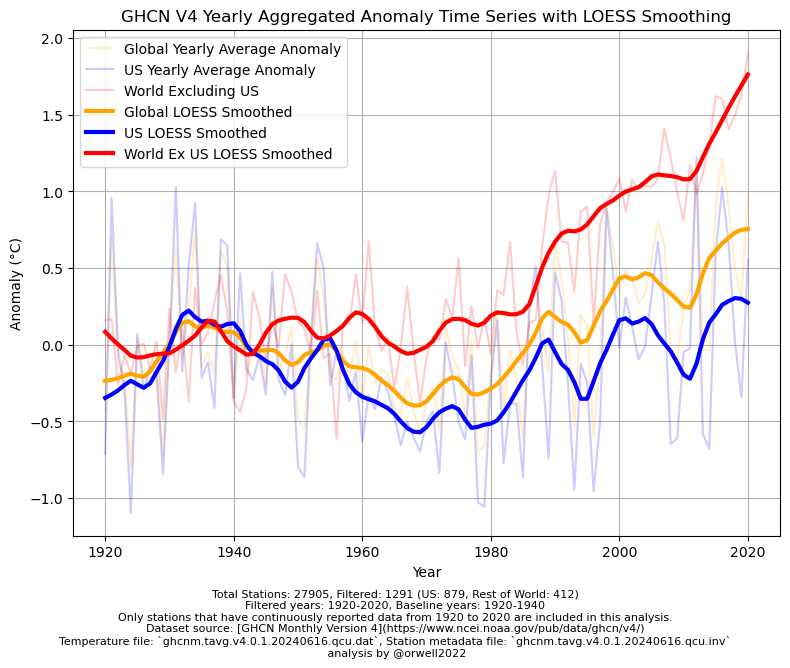

In [15]:
# Plot the anomaly time series with detailed footnotes
plot_anomaly_timeseries(anomaly_data, baseline_start, baseline_end, start_year, end_year, total_stations, filtered_stations, us_stations, world_ex_us_stations)


# Plot the station locations using Folium (only filtered stations with complete data)
stations = read_station_inventory(station_file_path)
plot_station_map_folium(stations, filtered_data)